# Gradient Boosting Machines (GBMs) with XGBoost

The following topics are covered in this notebook:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

In [1]:
!pip install numpy pandas matplotlib seaborn --quiet

You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.
ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "c:\program files (x86)\microsoft visual studio\shared\

In [5]:
!pip list | grep xgboost

xgboost                    1.4.2


You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.


## Problem Statement

This notebook takes a practical and coding-focused approach. We'll apply gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/rossmann-store-sales/rules) before executing the following cell.

In [9]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [10]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hasanainmehmood
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 6.99M/6.99M [00:01<00:00, 5.69MB/s]



Extracting archive .\rossmann-store-sales/rossmann-store-sales.zip to .\rossmann-store-sales


You'll be asked to provide your Kaggle credentials to download the data

In [12]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

Let's load the data into Pandas dataframes.

In [10]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [14]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [15]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [16]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [17]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [18]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [92]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


EDA could be performed at this stage

## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO


### Date

First, let's convert `Date` to a `datecolumn` and extract different parts of the date.

In [14]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [24]:
split_date(merged_df)
split_date(merged_test_df)

In [25]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [26]:
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [27]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [15]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [36]:
comp_months(merged_df)
comp_months(merged_test_df)

In [39]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


Let's view the results of the new columns we've created.

In [33]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
718806,2013-09-25,840.0,NaN,NaN,0.0
768155,2013-08-12,7830.0,2014.0,9.0,0.0
989812,2013-01-25,1940.0,2012.0,3.0,10.0
521249,2014-03-21,150.0,NaN,NaN,0.0
47293,2015-06-19,520.0,2009.0,3.0,75.0
412630,2014-06-27,9680.0,NaN,NaN,0.0
223153,2015-01-12,16420.0,NaN,NaN,0.0
111274,2015-04-23,4450.0,NaN,NaN,0.0
868021,2013-05-14,2170.0,2008.0,11.0,54.0
430097,2014-06-11,1150.0,NaN,NaN,0.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [16]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [41]:
promo_cols(merged_df)
promo_cols(merged_test_df)

Let's view the results of the columns we've created.

In [42]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
648279,2013-11-27,1,2013.0,1.0,"Jan,Apr,Jul,Oct",10.786885,0
751058,2013-08-27,1,2013.0,18.0,"Mar,Jun,Sept,Dec",3.901639,0
658594,2013-11-18,0,NaN,NaN,NaN,0.000000,0
411207,2014-06-28,0,NaN,NaN,NaN,0.000000,0
576152,2014-01-31,1,2010.0,13.0,"Jan,Apr,Jul,Oct",46.163934,1
942014,2013-03-09,1,2012.0,22.0,"Feb,May,Aug,Nov",9.245902,0
452075,2014-05-22,0,NaN,NaN,NaN,0.000000,0
984536,2013-01-30,1,2013.0,10.0,"Mar,Jun,Sept,Dec",0.000000,0
993396,2013-01-22,1,2011.0,40.0,"Jan,Apr,Jul,Oct",15.737705,1
625406,2013-12-18,1,2009.0,45.0,"Feb,May,Aug,Nov",49.377049,0


The features related to competition and promotion are now much more useful.

### Input and Target Columns

Let's select the columns that we'll use for training.

In [43]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [47]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [48]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [49]:
test_inputs = merged_test_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [50]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [51]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [52]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [54]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [55]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [56]:
from sklearn.preprocessing import MinMaxScaler

In [57]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [58]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [60]:
from sklearn.preprocessing import OneHotEncoder

In [61]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [62]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [63]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

> **EXERCISE**: Look through the notebooks created by participants in the Kaggle competition and apply some other ideas for feature engineering. https://www.kaggle.com/c/rossmann-store-sales/code?competitionId=4594&sortBy=voteCount

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

> **EXERCISE**: Can you describe in your own words how a gradient boosting machine is different from a random forest?


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)



### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [64]:
from xgboost import XGBRegressor

In [65]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

Let's train the model using `model.fit`.

In [66]:
%%time
model.fit(X, targets)

Wall time: 5.96 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

> **EXERCISE**: Explain how the `.fit` method of `XGBRegressor` applies the iterative machine learning workflow to train the model using the training data.
> 
> <img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [67]:
preds = model.predict(X)

In [68]:
preds

array([ 8127.9404,  7606.919 ,  8525.857 , ...,  6412.8247,  9460.068 ,
       10302.145 ], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [69]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [70]:
rmse(preds, targets)

2377.752008804669

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [86]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

In [87]:
#!pip install graphviz

In [93]:
#plot_tree(model, rankdir='LR');

In [95]:
#plot_tree(model, rankdir='LR', num_trees=1);

In [96]:
#plot_tree(model, rankdir='LR', num_trees=19);

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [97]:
trees = model.get_booster().get_dump()

In [98]:
len(trees)

20

In [99]:
print(trees[0])

0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<0.00220830599] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekOfYear<0.911764741] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<0.00800922886] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.00672379695] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<0.954545498] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<0.333333343] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<0.954545498] yes=13,no=14,missing=13
			13:[CompetitionDistance<0.00135135138] yes=27,no=28,missing=27
				27:le

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [100]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [101]:
importance_df.head(10)

,feature,importance
1,Promo,0.317473
24,StoreType_b,0.086472
12,DayOfWeek_1,0.082269
5,Promo2,0.063986
3,CompetitionDistance,0.045053
29,Assortment_c,0.040226
27,Assortment_a,0.038759
9,Month,0.038493
0,Store,0.038119
8,Day,0.033209


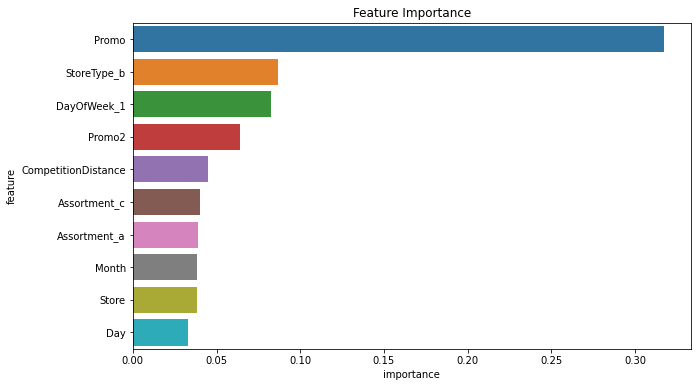

In [102]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

Scikit-learn provides utilities for performing K fold cross validation.

In [103]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [104]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [105]:
kfold = KFold(n_splits=5, shuffle=True)

In [106]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2386.9318693757227, Validation RMSE: 2392.9907523014795
Train RMSE: 2379.584576386279, Validation RMSE: 2390.151899282519
Train RMSE: 2379.8931495863458, Validation RMSE: 2370.840625364595
Train RMSE: 2400.207275632314, Validation RMSE: 2403.031705314847
Train RMSE: 2369.4574745332106, Validation RMSE: 2365.299445343096


Let's also define a function to average predictions from the 5 different models.

In [107]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [108]:
preds = predict_avg(models, X)

In [109]:
preds

array([ 8043.216 ,  7559.8   ,  8272.162 , ...,  7188.7705,  8457.8125,
       10055.248 ], dtype=float32)

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [111]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Here's a helper function to test hyperparameters with K-fold cross validation.

In [112]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [115]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.


In [116]:
test_params(n_estimators=10)

Train RMSE: 2374.4684335229995, Validation RMSE: 2400.8374930520513


In [117]:
test_params(n_estimators=30)

Train RMSE: 1899.8389586318056, Validation RMSE: 1919.0351468173064


In [118]:
test_params(n_estimators=100)

Train RMSE: 1180.9897374779057, Validation RMSE: 1192.7401883212292


In [119]:
test_params(n_estimators=240)

Train RMSE: 899.7912106726745, Validation RMSE: 919.0565059430505


> **EXERCISE**: Experiment with different values of `n_estimators`, plot a graph of the training and validation error and determine the best value for `n_estimators`.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [120]:
test_params(max_depth=2)

Train RMSE: 2346.6416059992007, Validation RMSE: 2371.4700049711646


In [121]:
test_params(max_depth=5)

Train RMSE: 1437.1226434160203, Validation RMSE: 1452.7625603690472


In [122]:
test_params(max_depth=10)

Train RMSE: 690.2606164864702, Validation RMSE: 783.348043369561


> **EXERCISE**: Experiment with different values of `max_depth`, plot a graph of the training and validation error and determine the optimal.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [123]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 5041.915843847942, Validation RMSE: 5072.739228056783


In [124]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2198.092315783356, Validation RMSE: 2222.6060493056943


In [125]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1526.182558629127, Validation RMSE: 1539.170582070613


In [126]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1136.3647956206578, Validation RMSE: 1150.1764849988156


In [127]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1125.6300568612758, Validation RMSE: 1145.5465877211004


> **EXERCISE**: Experiment with different values of `learning_rate`, plot a graph of the training and validation error and determine the optimal.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [128]:
test_params(booster='gblinear')

Train RMSE: 2724.3812276205426, Validation RMSE: 2753.460552111017


Clearly, a linear model is not well suited for this dataset.

> **EXERCISE**: Exeperiment with other hyperparameters like `gamma`, `min_child_weight`, `max_delta_step`, `subsample`, `colsample_bytree` etc. and find their optimal values. Learn more about them here: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

> **EXERCISE**: Train a model with your best hyperparmeters and evaluate its peformance using 5-fold cross validation.

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [130]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [131]:
%%time
model.fit(X, targets)

Wall time: 10min 13s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

Now that the model is trained, we can make predictions on the test set.

In [132]:
test_preds = model.predict(X_test)

Let's add the predictions into `submission_df`.

In [133]:
submission_df['Sales']  = test_preds

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [134]:
test_df.Open.isna().sum()

11

In [135]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [136]:
submission_df

,Id,Sales
0,1,5217.467773
1,2,7933.244629
2,3,8895.247070
3,4,7144.338867
4,5,6775.740723
...,...,...
41083,41084,3323.216309
41084,41085,7768.515137
41085,41086,6437.028809
41086,41087,22861.996094


We can now save the predictions as a CSV file.

In [137]:
submission_df.to_csv('submission.csv', index=None)

In [138]:
from IPython.display import FileLink

In [139]:
# Doesn't work on Colab, use the file browser instead.
FileLink('submission.csv')

C:\Users\92304\OneDrive - BLUE HORIZON CO. LTD\DS\jovian\Rossmann_store_sales_XGBoost\submission.csv

We can now make a submission on this page and check our score: https://www.kaggle.com/c/rossmann-store-sales/submit

![](https://i.imgur.com/bQ0lpSJ.png)

> **EXERCISE**: Save the model and all the other required objects using `joblib`.

In [2]:
import joblib
ross_sales_predictor = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

NameError: name 'model' is not defined

In [143]:
joblib.dump(ross_sales_predictor, 'ross_sales_predictor.joblib')

['ross_sales_predictor.joblib']

In [6]:
import joblib 
ross_sales_predictor = joblib.load('ross_sales_predictor.joblib')
ross_sales_predictor['input_cols']

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpen',
 'Day',
 'Month',
 'Year',
 'WeekOfYear',
 'Promo2',
 'Promo2Open',
 'IsPromo2Month']

> **EXERCISE**: Write a function `predict_input` which can make predictions for a single input provided as a dictionary. Make sure to include all the feature engineering and preprocessing steps. Refer to previous tutorials for hints.

In [65]:
import pandas as pd 
sample_input = {
    'Store':2,
    'DayOfWeek':4,
    'Promo':2,
    'Date':'2015-09-30',
    'Open':1,
    'StateHoliday':'a',
    'SchoolHoliday':0
    }
input_df = pd.DataFrame([sample_input])
input_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday
0,2,4,2,2015-09-30,1,a,0


In [66]:
#Merg With Store df
input_merged_df = input_df.merge(store_df, on='Store', how= 'left')
input_merged_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2,4,2,2015-09-30,1,a,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [67]:
##Feature Engineering
#Dates
split_date(input_merged_df)
#Competition
comp_months(input_merged_df)
#Promo2
promo_cols(input_merged_df)
input_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      1 non-null      int64         
 1   DayOfWeek                  1 non-null      int64         
 2   Promo                      1 non-null      int64         
 3   Date                       1 non-null      datetime64[ns]
 4   Open                       1 non-null      int64         
 5   StateHoliday               1 non-null      object        
 6   SchoolHoliday              1 non-null      int64         
 7   StoreType                  1 non-null      object        
 8   Assortment                 1 non-null      object        
 9   CompetitionDistance        1 non-null      float64       
 10  CompetitionOpenSinceMonth  1 non-null      float64       
 11  CompetitionOpenSinceYear   1 non-null      float64       
 12  Promo2      

In [68]:
##Preprocessing
# Imputation - Not Required
#Scaling
import numpy as np
input_merged_df[['WeekOfYear']] = input_merged_df[['WeekOfYear']].astype(np.int64, errors='ignore')
input_merged_df[ross_sales_predictor['numeric_cols']] = ross_sales_predictor['scaler'].transform(
                                                        input_merged_df[ross_sales_predictor['numeric_cols']])

#Encoding
input_merged_df[ross_sales_predictor['encoded_cols']] = ross_sales_predictor['encoder'].transform(
                                                        input_merged_df[ross_sales_predictor['categorical_cols']])

input_merged_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000898,4,2.0,2015-09-30,1,a,0.0,a,a,0.003626,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [72]:
#Selecting the right columns (numerical+encoded)
X_inputs = input_merged_df[ross_sales_predictor['numeric_cols']+ross_sales_predictor['encoded_cols']]
X_inputs
#Pass it into the model

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000898,2.0,0.0,0.003626,0.067821,1.0,0.919399,0.0,0.966667,0.727273,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [76]:
ross_sales_predictor['model'].predict(X_inputs)[0]

6946.0303